In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn

In [12]:


def generate_sine_wave(samples=1000, cycles=1):
    """
    Generates a sine wave array.

    Args:
        samples (int): The number of data points (default 1000).
        cycles (int): How many full sine cycles to generate within the array.

    Returns:
        tuple: (time_array, sine_array)
    """
    # Generate x values (time) from 0 to 2*pi * cycles
    # np.linspace creates evenly spaced numbers over a specified interval
    t = np.linspace(0, 2 * np.pi * cycles, samples)

    # Calculate the sine of x
    y = np.sin(t)

    return torch.tensor(y).float().cuda()

sine_wave = generate_sine_wave()

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.gru = nn.GRU(1, 16, 1)
        self.l1 = nn.Linear(16, 1)


    def forward(self, x, h0):

        y, h1 = self.gru(x, h0)

        return self.l1(y), h1

In [17]:
# training a GRU
model = Model().cuda().train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)
loss_fn = nn.MSELoss()
sine_wave = generate_sine_wave()

h0 = torch.zeros((1, 1, 16)).cuda()

print(sine_wave.shape)
for i in range(10000):
    x = sine_wave[:-1].unsqueeze(1).unsqueeze(1)
    y_hat = sine_wave[1:].unsqueeze(1).unsqueeze(1)
    y, _ = model(x, h0)

    loss = loss_fn(y_hat, y)

    if i % 1000 == 0:
        print(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

torch.Size([1000])
tensor(0.4674, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0570e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(4.7497e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5093e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0827e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4854e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.9699e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.9840e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4061e-07, device='cuda:0', grad_fn=<MseLossBackward0>)


In [36]:
# running GRU inference

# let's say we use the first 200 elements to predict the next 800
model.eval()
x = sine_wave[:1].unsqueeze(0).unsqueeze(-1)
h = torch.zeros((1, 1, 16)).cuda()

for i in range(999):

    x_h, h_h = model(x, h)
    #print(x.shape)
    #print(x_h[:, -1, :].unsqueeze(-2).shape)
    x = torch.cat([x, x_h[:, -1:, :]], dim=1)
    h = torch.cat([h, h_h[:, -1:, :]], dim=1)

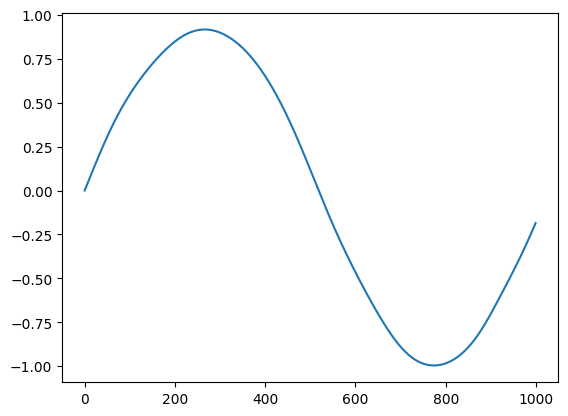

In [37]:
# Plotting to make sure it's correct

fig, ax = plt.subplots()             # Create a figure containing a single Axes.
ax.plot(x[0, :, 0].detach().cpu().numpy())  # Plot some data on the Axes.
plt.show()